# Import Library

In [ ]:
import pandas as pd
import numpy as np

!pip -q install Sastrawi

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import string
import re
from collections import Counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.6 MB/s eta 0:00:00


In [ ]:
data = pd.read_excel('/content/sample_data/Data Comment Youtube Skripsi Awal.xlsx')
data.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,Ulasan
0,alhamdulillah masih diberikan kesehatan dan me...
1,semoga resesinya ngga terlalu berpengaruh ke i...
2,ayo nabung dan tetap beli produk asli Indonesi...
3,Semoga bisa bertahan di tengah tengah badai kr...
4,Kalau ngga mau resesi petani diprioritaskan do...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Ulasan  1644 non-null   object
dtypes: object(1)
memory usage: 13.0+ KB


In [ ]:
data.dropna(inplace=True)

#Label

In [ ]:
post_words = pd.read_csv('https://github.com/fajri91/InSet/raw/master/positive.tsv',delimiter='\t')
neg_words = pd.read_csv('https://github.com/fajri91/InSet/raw/master/negative.tsv',delimiter='\t')

sent_words = pd.concat([post_words,neg_words]).set_index('word').to_dict()['weight']

In [ ]:
post_words = pd.read_csv('https://github.com/fajri91/InSet/raw/master/positive.tsv',delimiter='\t').set_index('word').to_dict()['weight']
neg_words = pd.read_csv('https://github.com/fajri91/InSet/raw/master/negative.tsv',delimiter='\t').set_index('word').to_dict()['weight']

In [ ]:
sentiment_scores = []
for text in data['Ulasan']:
  score = 0
  for wd in sent_words.keys():
    if wd in text.lower():
      score += sent_words[wd]
    else:
      score += 0
  sentiment_scores.append(score)

#Pre Processing

In [ ]:
factory_stopword = StopWordRemoverFactory()
stopword = factory_stopword.create_stop_word_remover()

factory_stemmer = StemmerFactory()
stemmer = factory_stemmer.create_stemmer()

In [ ]:
coll_id = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')[['slang','formal']]
coll_id

,slang,formal
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa
...,...,...
15001,gataunya,enggak taunya
15002,gtau,enggak tau
15003,gatau,enggak tau
15004,fans2,fan-fan


In [ ]:
words_dict = pd.read_excel('/content/sample_data/dictionary kata.xlsx').fillna('').set_index('Kata').rename({'Replace':'formal'},axis=1)
words_dict

,formal,Unnamed: 2
Kata,,
,,
a,,
aammiinnn,amiin,
aammiinnnnn,amiin,
abal,abal,
...,...,...
yusuf,,
zikir,,
zmn,,


In [ ]:
coll_dict = coll_id.set_index('slang')
coll_dict

,formal
slang,
woww,wow
aminn,amin
met,selamat
netaas,menetas
keberpa,keberapa
...,...
gataunya,enggak taunya
gtau,enggak tau
gatau,enggak tau


In [ ]:
words_dict = pd.concat([coll_dict,words_dict[['formal']]])['formal'].to_dict()

In [ ]:
tmp = []
for text in data['Ulasan'].str.lower():
  words = text.split(' ')
  new_words=[]
  for word in words:
    try:
      new_words.append(words_dict[word])
    except:
      new_words.append(word)
  tmp.append(' '.join(new_words))

data['Ulasan_preproc'] = tmp

In [ ]:
stopwords_id = pd.read_csv('https://github.com/stopwords-iso/stopwords-id/raw/master/stopwords-id.txt',header=None)[0].values

In [ ]:
def case_folding(text):
    # Mengubah ke lower case
    text_new = text.lower()
    # Membuat kamus translasi untuk menghapus tanda baca
    text_new = re.sub("[^A-Za-z\s]"," ", text_new) #Menghilangkan yang bukan huruf
    text_new = re.sub("[0-9']"," ", text_new)
    text_new = re.sub(r"\\n"," ",text_new)

    text_new = ' '.join([wd if wd not in stopwords_id else '' for wd in text.split(' ')])

    text_new = ' '.join([stemmer.stem(word) for word in text_new.split()])

    return text_new

# Menghapus tanda baca dari teks
data['Ulasan_preproc'] = data['Ulasan_preproc'].apply(lambda x: case_folding(x))

#Label

In [ ]:
post_words = pd.read_csv('https://github.com/fajri91/InSet/raw/master/positive.tsv',delimiter='\t').set_index('word').to_dict()['weight']
neg_words = pd.read_csv('https://github.com/fajri91/InSet/raw/master/negative.tsv',delimiter='\t').set_index('word').to_dict()['weight']

In [ ]:
sentiment_scores = []
for text in data['Ulasan_preproc']:
  post = 0
  neg = 0
  for wd in post_words.keys():
    if wd in text.lower():
      post += 1

  for wd in neg_words.keys():
    if wd in text.lower():
      neg += 1

  sentiment_scores.append(post-neg)

In [ ]:
data['sent_score'] = sentiment_scores
data['label'] = data['sent_score'].apply(lambda x: 'Positive' if x>=0 else 'Negative')

In [ ]:
data.head()

,Ulasan,Ulasan_preproc,sent_score,label
0,alhamdulillah masih diberikan kesehatan dan me...,alhamdulillah sehat tabung negara orang moga p...,0,Positive
1,semoga resesinya ngga terlalu berpengaruh ke i...,moga resesi pengaruh indonesia moga jalan peri...,0,Positive
2,ayo nabung dan tetap beli produk asli Indonesi...,ayo nabung beli produk asli indonesia resesi,0,Positive
3,Semoga bisa bertahan di tengah tengah badai kr...,moga tahan badai krisis global pasca pandemi,0,Positive
4,Kalau ngga mau resesi petani diprioritaskan do...,resesi tani prioritas cekek terus koruptor bun...,0,Positive


<Axes: >

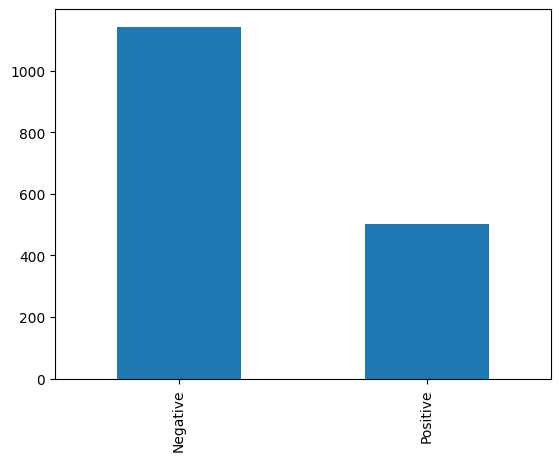

In [ ]:
data['label'].value_counts().plot(kind='bar')

In [ ]:
data.label.value_counts()

Negative    1142
Positive     502
Name: label, dtype: int64

<Axes: >

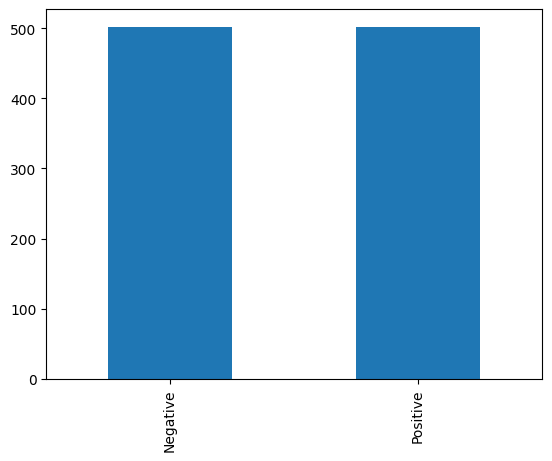

In [ ]:
pos = data[data['label']=='Positive']
neg = data[data['label']=='Negative'].sample(len(pos))

new_dat = pd.concat([neg,pos])
new_dat = new_dat.sample(len(new_dat))

new_dat.label.value_counts().plot(kind='bar')

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(new_dat, train_size=0.80,stratify=new_dat['label'])

#Tokenisasi

In [ ]:
tokens_train = []
tokens_test = []

for text in train['Ulasan_preproc']:
  tokens_train.append(text.split(' '))

for text in test['Ulasan_preproc']:
  tokens_test.append(text.split(' '))

## Define TF-IDF

In [ ]:
vocab_train = []
for token in tokens_train:
  vocab_train += token

vocab_train = list(set(vocab_train))

In [ ]:

class TFIDF:
  def __init__(self):
    self.vocabs = None
    self.tf_values = None
    self.df_values = None
    self.tfidf_values = None
    self.words_filter = None

  def vocab_counter(self):
    vocab_train = []
    for token in self.tokens:
      vocab_train += token
    return list(set(vocab_train))

  def tf(self,tokens):
    tf_list = []
    for token in tokens:
      tf_list.append({word: token.count(word)/len(token) for word in token})
    return tf_list

  def df(self,tokens):
    df_terms = {word: 0 for word in self.vocabs}
    for token in tokens:
      for word in token:
        df_terms[word] += 1
    return df_terms

  def idf(self,tokens):
    return {word: np.log(len(tokens)/self.df_values[word]) for word in self.df_values}

  def tf_idf(self,tf_dict):

    tfidf_values = []
    for token in tf_dict:
      tfidf_values.append({word: token[word] * self.idf_values[word] if word in token.keys() else 0 for word in self.idf_values})
    return pd.DataFrame(tfidf_values)

  def fit(self,tokens,n_filter=3):
    self.tokens = tokens
    self.vocabs = self.vocab_counter()
    self.tf_values = self.tf(self.tokens)
    self.df_values = self.df(self.tokens)
    self.idf_values = self.idf(self.tokens)
    self.tfidf_values = self.tf_idf(self.tf_values)

    words_df = pd.Series(self.df_values)
    words_df = words_df[(words_df >= n_filter) & (words_df != '')].sort_values()
    self.words_filter = words_df.index.tolist()

    self.tfidf_values = self.tfidf_values[self.words_filter]

  def transform(self,tokens):
    tf_val = self.tf(tokens)
    tf_idf_val = pd.DataFrame(self.tf_idf(tf_val))
    return tf_idf_val[self.words_filter]

In [ ]:
tfidf_transform = TFIDF()
tfidf_transform.fit(tokens_train,n_filter=5)

In [ ]:
X_train = tfidf_transform.transform(tokens_train)
X_test = tfidf_transform.transform(tokens_test)

X_train_reshape = X_train.values.reshape(X_train.shape[0],X_train.shape[-1],1)
X_test_reshape = X_test.values.reshape(X_test.shape[0],X_test.shape[-1],1)

y_train=train['label'].replace({'Positive':1,'Negative':0}).values
y_test=test['label'].replace({'Positive':1,'Negative':0}).values

# Model

## Mendefinisikan Fungsi Matematis

In [ ]:
# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid
def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
  return np.maximum(0,x)

def relu_derivative(x):
  np.where(x <=0, 0, 1)

# Binary cross-entropy loss function
def binary_crossentropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Derivative of binary cross-entropy loss
def binary_crossentropy_derivative(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return (y_pred - y_true) / (y_pred * (1 - y_pred))

## Mendefinisikan layer LSTM

In [ ]:
class LSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize weights and biases
        self.W_f = np.random.rand(hidden_size, input_size + hidden_size)
        self.b_f = np.zeros((hidden_size, 1))
        self.W_i = np.random.rand(hidden_size, input_size + hidden_size)
        self.b_i = np.zeros((hidden_size, 1))
        self.W_c = np.random.rand(hidden_size, input_size + hidden_size)
        self.b_c = np.zeros((hidden_size, 1))
        self.W_o = np.random.rand(hidden_size, input_size + hidden_size)
        self.b_o = np.zeros((hidden_size, 1))

        # Cell state and hidden state
        self.c = np.zeros((hidden_size, 1))
        self.h = np.zeros((hidden_size, 1))
        self.c_states = []
        self.h_states = []

        self.f = None
        self.i = None
        self.c_hat = None
        self.o = None

        self.dW_f = None
        self.db_f = None
        self.dW_i = None
        self.db_i = None
        self.dW_c = None
        self.db_c = None
        self.dW_o = None
        self.db_o = None

    def forward(self, x):
        for t in range(len(x)):
          concat_input = np.vstack((x[t], self.h))

          self.f = sigmoid(np.dot(self.W_f, concat_input) + self.b_f)
          self.i = sigmoid(np.dot(self.W_i, concat_input) + self.b_i)
          self.c_hat = np.tanh(np.dot(self.W_c, concat_input) + self.b_c)
          self.c = self.f * self.c + self.i * self.c_hat
          self.o = sigmoid(np.dot(self.W_o, concat_input) + self.b_o)
          self.h = self.o * np.tanh(self.c)

          self.c_states.append(self.c)
          self.h_states.append(self.h)

        return self.h


    def backward(self, x, dh_next, dc_next, learning_rate):

        for t in reversed(range(len(x))):
          concat_input = np.vstack((x[t], self.h_states[t]))

          # Gradients
          do = dh_next * np.tanh(self.c_states[t])
          dc = dc_next + dh_next * self.o * (1 - np.tanh(self.c_states[t])**2)

          df = dc * self.c_states[t]
          di = dc * self.c_hat
          dc_hat = dc * self.i
          #dg = dc * f

          # Gradients with respect to inputs and parameters
          self.dW_f = np.dot(df * sigmoid_derivative(self.f), concat_input.T)
          self.db_f = np.sum(df * sigmoid_derivative(self.f), axis=1, keepdims=True)
          self.dW_i = np.dot(di * sigmoid_derivative(self.i), concat_input.T)
          self.db_i = np.sum(di * sigmoid_derivative(self.i), axis=1, keepdims=True)
          self.dW_c = np.dot(dc_hat * (1 - np.tanh(self.c_hat)**2), concat_input.T)
          self.db_c = np.sum(dc_hat * (1 - np.tanh(self.c_hat)**2), axis=1, keepdims=True)
          self.dW_o = np.dot(do * sigmoid_derivative(self.o), concat_input.T)
          self.db_o = np.sum(do * sigmoid_derivative(self.o), axis=1, keepdims=True)

          # Gradients with respect to input and hidden state
          dx = np.dot(self.W_f[:, :self.input_size].T, df * sigmoid_derivative(self.f)) + \
              np.dot(self.W_i[:, :self.input_size].T, di * sigmoid_derivative(self.i)) + \
              np.dot(self.W_c[:, :self.input_size].T, dc_hat * (1 - np.tanh(self.c_hat)**2)) + \
              np.dot(self.W_o[:, :self.input_size].T, do * sigmoid_derivative(self.o))
          dh = np.dot(self.W_f[:, self.input_size:].T, df * sigmoid_derivative(self.f)) + \
              np.dot(self.W_i[:, self.input_size:].T, di * sigmoid_derivative(self.i)) + \
              np.dot(self.W_c[:, self.input_size:].T, dc_hat * (1 - np.tanh(self.c_hat)**2)) + \
              np.dot(self.W_o[:, self.input_size:].T, do * sigmoid_derivative(self.o))

          # Update parameters
          self.W_f -= learning_rate * self.dW_f
          self.b_f -= learning_rate * self.db_f
          self.W_i -= learning_rate * self.dW_i
          self.b_i -= learning_rate * self.db_i
          self.W_c -= learning_rate * self.dW_c
          self.b_c -= learning_rate * self.db_c
          self.W_o -= learning_rate * self.dW_o
          self.b_o -= learning_rate * self.db_o

        return dx[:self.input_size], dh, dc

## Mendefinisikan Layer Dense

In [ ]:
class Dense:
    def __init__(self, input_size, output_size, activation='sigmoid'):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation

        # Initialize weights and biases
        self.W = np.random.rand(output_size, input_size)
        self.b = np.zeros((output_size, 1))

        self.dW = None
        self.db = None
        self.dx = None

    def forward(self, x):
        # Forward pass
        actv={"sigmoid":sigmoid, "relu":relu}

        self.x = x
        self.z = np.dot(self.W, x) + self.b
        self.a = actv[self.activation](self.z)
        return self.a

    def backward(self, dz, learning_rate):
        # Backward pass
        actv_div = {"sigmoid":sigmoid_derivative,"relu":relu_derivative}

        self.dx = np.dot(self.W.T, dz * actv_div[self.activation](self.a))
        self.dW = np.dot(dz * actv_div[self.activation](self.a), self.x.T)
        self.db = np.sum(dz * actv_div[self.activation](self.a), axis=1, keepdims=True)

        # Update parameters
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db

        return self.dx

## Mendefinisilan kelas Model untuk compile layer

In [ ]:
class Model:
  def __init__(self,sequence):
    self.sequence = sequence

  def predict(self,X):
    y = None
    predictions = []
    for x in X:
      for i,layer in enumerate(self.sequence):
        if i == 0:
          y = layer.forward(x)
        else:
          y = layer.forward(y)
      predictions.append(y)
    return np.array(predictions)

  def fit(self, X_train, y_train, epochs, learning_rate, vals=None, metric='accuracy'):

    metrics = {'accuracy':accuracy_score,'recall':recall_score,'precision':precision_score,'f1':f1_score}

    history = {f'{metric}_train':[],
               f'{metric}_val':[],
               f'loss_train':[],
               f'loss_val':[]}

    for e in range(epochs):
      ys = []
      for j in range(len(X_train)):
        inputs = [X_train[j]]
        for i,layer in enumerate(self.sequence):
          if i == 0:
            y_pred = layer.forward(X_train[j])
          else:
            y_pred = layer.forward(y_pred)

          inputs.append(y_pred)

        loss = binary_crossentropy(y_train[j], y_pred)
        ys.append(int(np.round(y_pred)))

        dy = binary_crossentropy_derivative(y_train[j], y_pred)

        for i,layer in enumerate(reversed(self.sequence)):
          if i == 0:
            dlayer = layer.backward(dy,learning_rate=learning_rate)
          elif isinstance(layer,Dense):
            dlayer = layer.backward(dlayer,learning_rate=learning_rate)
          elif isinstance(layer, LSTM):
            dc_lstm = np.zeros_like(layer.c)
            dx_lstm, dlayer, dc_lstm = layer.backward(inputs[::-1][1:][i], dlayer, dc_lstm,learning_rate=learning_rate)

      metric_score = accuracy_score(y_train,ys)

      history[f'{metric}_train'].append(metric_score)
      history['loss_train'].append(loss)

      if vals != None:
        y_pred_val = self.predict(vals[0])
        history[f'{metric}_val'].append(metrics[metric](vals[1],y_pred_val))
        history['loss_val'].append(np.mean(binary_crossentropy(vals[1],y_pred_val)))

    return history
